In [1]:
# CELL 1: SETUP & MERGING
import pandas as pd
import glob
import os

# 1. SETUP: Universal Path Logic
# os.getcwd() gets the "Current Working Directory" where this notebook is running
folder_path = os.getcwd()
print(f"📂 Working Directory: {folder_path}")

# Optional: If you keep data in a subfolder (e.g., 'data'), uncomment the line below:
# folder_path = os.path.join(folder_path, 'data')

# Set the working directory explicitly (good practice for stability)
os.chdir(folder_path)

# 2. MERGE FUNCTION
def load_and_merge(pattern, name):
    # Search for files matching the pattern in the current folder
    files = glob.glob(pattern)
    print(f"[{name}] Found {len(files)} files.")
    
    dfs = []
    for f in files:
        try:
            # low_memory=False handles mixed types safely
            df = pd.read_csv(f, low_memory=False)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading {f}: {e}")
            
    if dfs:
        master = pd.concat(dfs, ignore_index=True)
        # Standardize headers immediately
        master.columns = master.columns.str.strip().str.lower()
        print(f"✅ Loaded {len(master):,} rows for {name}.")
        return master
    else:
        print(f"⚠️ No files found for {name}. Check if CSVs are in the folder.")
        return None

# 3. EXECUTE LOAD
# Note: This expects the CSV files to be in the SAME folder as this notebook file.
df_enrolment = load_and_merge('*enrolment*.csv', 'Enrolment')
df_biometric = load_and_merge('*biometric*.csv', 'Biometric')
df_demographic = load_and_merge('*demographic*.csv', 'Demographic')

📂 Working Directory: C:\Users\saikr\Documents\UIDAI_PROJECT
[Enrolment] Found 3 files.
✅ Loaded 1,006,029 rows for Enrolment.
[Biometric] Found 4 files.
✅ Loaded 1,861,108 rows for Biometric.
[Demographic] Found 5 files.
✅ Loaded 2,071,700 rows for Demographic.


In [2]:
# --- CELL 2: THE FINAL "GOLDEN" CLEANER (LOCKED AT 776) ---
import pandas as pd
import numpy as np

def master_clean_geography(df):
    if df is None or df.empty:
        return None

    print("   ...Cleaning geography...")
    
    # 1. DROP PINCODES & UNWANTED COLUMNS
    if 'pincode' in df.columns:
        df = df.drop(columns=['pincode'])
    
    # 2. REMOVE GARBAGE ROWS
    garbage_districts = [
        '100000', '5Th Cross', '?', 'Idpl Colony', 'Near Meera Hospital', 
        'Near Uday Nagar Nit Garden', 'Near Dhyana Ashram', 'Near University Thana',
        'Naihati Anandabazar', 'South Dumdum M', 'South Dumdum(M)', 
        'Bally Jagachha', 'District', 'Kadiri Road', 'East', 'North', 'South', 'West',
        'Akhera', 'Domjur', 'Najafgarh'
    ]
    
    if 'district' in df.columns:
        df = df[~df['district'].isin(garbage_districts)]
        
        # --- 3. AGGRESSIVE STRING CLEANING (REGEX) ---
        df['district'] = df['district'].astype(str)
        # Remove "Dist :" prefix
        df['district'] = df['district'].str.replace(r'^Dist\s*:\s*', '', regex=True, case=False)
        # Remove suffixes like "District", "Dist", "Dt" at the end
        df['district'] = df['district'].str.replace(r'\s+District$', '', regex=True, case=False)
        df['district'] = df['district'].str.replace(r'\s+Dist\.?$', '', regex=True, case=False)
        df['district'] = df['district'].str.replace(r'\s+Dt\.?$', '', regex=True, case=False)
        # Remove Special Characters: * ? ( )
        df['district'] = df['district'].str.replace(r'[*?]', '', regex=True)
        df['district'] = df['district'].str.strip()

    # 4. STANDARDIZE STATE NAMES
    state_map = {
        'Andaman & Nicobar Islands': 'Andaman And Nicobar Islands',
        'Chhatisgarh': 'Chhattisgarh',
        'Jammu & Kashmir': 'Jammu And Kashmir',
        'Tamilnadu': 'Tamil Nadu',
        'West  Bengal': 'West Bengal', 'Westbengal': 'West Bengal', 'W.B.': 'West Bengal','Orissa': 'Odisha', 'Pondicherry': 'Puducherry', 'Uttaranchal': 'Uttarakhand','Daman & Diu': 'Dadra And Nagar Haveli And Daman And Diu','Daman And Diu': 'Dadra And Nagar Haveli And Daman And Diu','The Dadra And Nagar Haveli And Daman And Diu': 'Dadra And Nagar Haveli And Daman And Diu','Dadra And Nagar Haveli': 'Dadra And Nagar Haveli And Daman And Diu','Dadra   Nagar Haveli': 'Dadra And Nagar Haveli And Daman And Diu','Dadra & Nagar Haveli': 'Dadra And Nagar Haveli And Daman And Diu','Delhi': 'Nct Of Delhi','New Delhi': 'Nct Of Delhi'
    }
    
    if 'state' in df.columns:
        df['state'] = df['state'].replace(state_map)
        df['state'] = df['state'].str.title().str.strip()
        df['state'] = df['state'].replace(state_map) 

    # 5. AURANGABAD SAFETY LOCK (The Logic Fix)
    if 'state' in df.columns and 'district' in df.columns:
        mask_mh_aurangabad = (df['state'] == 'Maharashtra') & (df['district'].str.contains('Aurangabad', case=False, na=False))
        df.loc[mask_mh_aurangabad, 'district'] = 'Chhatrapati Sambhajinagar'

    # 6. STANDARDIZE DISTRICT NAMES (COMPLETE MAP)
    district_map = {
        # --- A ---
        'Ahmadabad': 'Ahmedabad', 'Ahmed Nagar': 'Ahmednagar', 'Ahilyanagar': 'Ahmednagar',
        'Allahabad': 'Prayagraj', 'Almora': 'Almora',
        'Ananthapur': 'Anantapur', 'Ananthapuramu': 'Anantapur',
        'Anugul': 'Angul', 'Anugal': 'Angul', 
        'Ashok Nagar': 'Ashoknagar', # Added from your list
        'Aurangabad(Bh)': 'Aurangabad', 
        'Aurangabad': 'Chhatrapati Sambhajinagar', 

        # --- B ---
        'Bagpat': 'Baghpat', 'Baleswar': 'Baleshwar', 
        'Ballari': 'Ballari', 'Bellary': 'Ballari',
        'Banas Kantha': 'Banaskantha', 'Bandipore': 'Bandipur', 
        'Bangalore': 'Bengaluru', 'Bangalore Rural': 'Bengaluru Rural', 'Bengaluru South': 'Bengaluru',
        'Bengaluru Urban': 'Bengaluru', # Added from your list
        'Bara Banki': 'Barabanki', 'Baramula': 'Baramulla',
        'Barddhaman': 'Purba Bardhaman', 'Bardhaman': 'Purba Bardhaman', 'Burdwan': 'Purba Bardhaman',
        'Baudh': 'Boudh', 'Belgaum': 'Belagavi', 
        'Bhadrak(R)': 'Bhadrak', 'Bhadrak R': 'Bhadrak',
        'Bhabua': 'Kaimur', 'Kaimur (Bhabua)': 'Kaimur',
        'Bid': 'Beed',
        'Bijapur(Kar)': 'Vijayapura', 'Bijapur Kar': 'Vijayapura', 'Bijapur': 'Vijayapura',
        'Bulandshahar': 'Bulandshahr', 'Buldana': 'Buldhana',

        # --- C ---
        'Chamrajanagar': 'Chamarajanagar', 'Chamrajnagar': 'Chamarajanagar',
        'Chatrapati Sambhaji Nagar': 'Chhatrapati Sambhajinagar',
        'Central Delhi': 'Central Delhi',
        'Chickmagalur': 'Chikkamagaluru', 'Chikmagalur': 'Chikkamagaluru',
        'Chittaurgarh': 'Chittorgarh', 
        'Coochbehar': 'Cooch Behar', 'Koch Bihar': 'Cooch Behar',
        'Cuddapah': 'YSR', 

        # --- D ---
        'Dadra   Nagar Haveli': 'Dadra And Nagar Haveli', 'Dadra & Nagar Haveli': 'Dadra And Nagar Haveli',
        'Dakshin Bastar Dantewada': 'Dantewada', 
        'Dinajpur Dakshin': 'Dakshin Dinajpur', 'South Dinajpur': 'Dakshin Dinajpur',
        'Dinajpur Uttar': 'Uttar Dinajpur', # Added from your list
        'Darjiling': 'Darjeeling', 
        'Davanagere': 'Davanagere', 'Davangere': 'Davanagere',
        'Dhaulpur': 'Dholpur', 'Dohad': 'Dahod', 
        'Dist : Thane': 'Thane',
        'Dr  B  R  Ambedkar Konaseema': 'Dr B R Ambedkar Konaseema', 
        'Dr. B. R. Ambedkar Konaseema': 'Dr B R Ambedkar Konaseema',

        # --- E, F, G, H ---
        'East Midnapore': 'Purba Medinipur', 'East Midnapur': 'Purba Medinipur',
        'East Nimar': 'Khandwa', 'East Singhbum': 'East Singhbhum',
        'Faizabad': 'Ayodhya', 
        'Firozpur': 'Ferozepur', # Added from your list
        'Gaurella Pendra Marwahi': 'Gaurela Pendra Marwahi', 'Gaurela-Pendra-Marwahi': 'Gaurela Pendra Marwahi',
        'Gondiya': 'Gondia',
        'Gulbarga': 'Kalaburagi', 'Gurgaon': 'Gurugram',
        'Haora': 'Howrah', 'Hawrah': 'Howrah', 'Hardwar': 'Haridwar',
        'Hazaribag': 'Hazaribagh', 
        'Hooghiy': 'Hooghly', 'Hugli': 'Hooghly',
        'Hoshangabad': 'Narmadapuram',

        # --- J, K ---
        'Jagatsinghapur': 'Jagatsinghpur', 'Jagitial': 'Jagtial', 'Jajapur': 'Jajpur',
        'Jalor': 'Jalore', 'Jangoan': 'Jangaon', 
        'Janjgir   Champa': 'Janjgir Champa', 'Janjgir - Champa': 'Janjgir Champa', 'Janjgir-Champa': 'Janjgir Champa',
        'Jhunjhunun': 'Jhunjhunu',
        'Jyotiba Phule Nagar': 'Amroha',
        'K V  Rangareddy': 'Rangareddy', 'K.V. Rangareddy': 'Rangareddy', 'K.V.Rangareddy': 'Rangareddy',
        'Kabeerdham': 'Kawardha', 
        'Kancheepuram': 'Kanchipuram', 
        'Kanker': 'Uttar Bastar Kanker',
        'Kanniyakumari': 'Kanyakumari', 'Karim Nagar': 'Karimnagar', 'Kasargod': 'Kasaragod',
        'Kheri': 'Lakhimpur Kheri', 'Lakhimpur': 'Lakhimpur Kheri',
        'Khorda': 'Khordha', 
        'Koderma': 'Kodarma', # Added from your list
        'Kushi Nagar': 'Kushinagar',

        # --- L, M ---
        'Lahul   Spiti': 'Lahaul And Spiti', 'Lahul And Spiti': 'Lahaul And Spiti', 'Lahul & Spiti': 'Lahaul And Spiti',
        'Leh  Ladakh': 'Leh', 'Leh (Ladakh)': 'Leh',
        'Mahabub Nagar': 'Mahabubnagar', 'Mahbubnagar': 'Mahabubnagar',
        'Mahrajganj': 'Maharajganj', 'Maldah': 'Malda', 'Mammit': 'Mamit',
        'Manendragarhchirmiribharatpur': 'Manendragarh Chirmiri Bharatpur',
        'Manendragarh–Chirmiri–Bharatpur': 'Manendragarh Chirmiri Bharatpur',
        
        # *** FIXING MEDCHAL ***
        'Medchal': 'Medchal Malkajgiri', 
        'Medchalmalkajgiri': 'Medchal Malkajgiri',
        'Medchalâˆ’Malkajgiri': 'Medchal Malkajgiri', 
        'Medchalâ  Malkajgiri': 'Medchal Malkajgiri',
        'Medchal-Malkajgiri': 'Medchal Malkajgiri', 
        'Medchal−Malkajgiri': 'Medchal Malkajgiri',
        
        'Medinipur': 'Paschim Medinipur', 'Medinipur West': 'Paschim Medinipur',
        'Mewat': 'Nuh',
        'Mohalla Manpur Ambagarh Chowki': 'Mohla Manpur Ambagarh Chowki', 
        'Mohla-Manpur-Ambagarh Chouki': 'Mohla Manpur Ambagarh Chowki', 'Mohalla-Manpur-Ambagarh Chowki': 'Mohla Manpur Ambagarh Chowki',
        'Monghyr': 'Munger',
        'Mumbai  Sub Urban': 'Mumbai', 'Mumbai City': 'Mumbai', 'Mumbai Suburban': 'Mumbai', 'Mumbai( Sub Urban )': 'Mumbai',
        'Muktsar': 'Sri Muktsar Sahib', 'Mysore': 'Mysuru',

        # --- N ---
        'N  T  R': 'NTR', 'N. T. R': 'NTR',
        'Nabarangapur': 'Nabarangpur', 'Narsimhapur': 'Narsinghpur', 
        'Nicobars': 'Nicobar',
        # *** FIXING NORTH 24 PARGANAS ***
        'North 24 Parganas': 'North 24 Parganas', 
        '24 Paraganas North': 'North 24 Parganas', # Added from your list
        'North Twenty Four Parganas': 'North 24 Parganas',
        
        'North Cachar Hills': 'Dima Hasao',
        'North Dinajpur': 'Uttar Dinajpur', 
        'North East': 'North East Delhi', 
        'North And Middle Andaman': 'Andamans', 'South Andaman': 'Andamans',

        # --- O, P, R ---
        'Osmanabad': 'Dharashiv', 'Pakaur': 'Pakur', # Pakaur fixed
        'Palamau': 'Palamu', 'Panchmahals': 'Panch Mahals',
        'Paschim Champaran': 'West Champaran', 'Pashchim Champaran': 'West Champaran',
        'Pashchimi Singhbhum': 'West Singhbhum',
        'Pondicherry': 'Puducherry', # Fixed
        'Punch': 'Poonch',
        'Purba Champaran': 'East Champaran', 'Purbi Champaran': 'East Champaran', 
        'Purbi Singhbhum': 'East Singhbhum', 'Purnea': 'Purnia', 'Puruliya': 'Purulia',
        'Rae Bareli': 'Raebareli', 
        'Raigarh Mh': 'Raigad', 'Raigarh(Mh)': 'Raigad',
        'Rajauri': 'Rajouri', # Fixed
        'Ramanagar': 'Ramanagara', 
        'Rangareddi': 'Rangareddy', 'Ranga Reddy': 'Rangareddy',

        # --- S ---
        'S A S Nagar': 'Mohali', 'S.A.S Nagar': 'Mohali', 'S.A.S Nagar(Mohali)': 'Mohali', 'Sas Nagar (Mohali)': 'Mohali',
        'Sabarkantha': 'Sabarkantha', 'Sabar Kantha': 'Sabarkantha',
        'Sahebganj': 'Sahibganj', 'Samstipur': 'Samastipur',
        'Sant Ravidas Nagar': 'Bhadohi', 'Sant Ravidas Nagar Bhadohi': 'Bhadohi',
        'Sarangarh-Bilaigarh': 'Sarangarh Bilaigarh',
        'Shaheed Bhagat Singh Nagar': 'Nawanshahr',
        'Sheikhpura': 'Sheikhpura', 'Sheikpura': 'Sheikhpura',
        'Shimoga': 'Shivamogga', 'Shupiyan': 'Shopian',
        'Shrawasti': 'Shravasti', # Fixed
        'Sibsagar': 'Sivasagar', 'Siddharth Nagar': 'Siddharthnagar',
        'Sonapur': 'Subarnapur',
        
        # *** FIXING SOUTH 24 PARGANAS ***
        'South 24 Pargana': 'South 24 Parganas',
        '24 Paraganas South': 'South 24 Parganas', # Added from your list
        'South Twenty Four Parganas': 'South 24 Parganas',
        'South  Twenty Four Parganas': 'South 24 Parganas', # Added from your list (double space)
        
        'South Dinajpur': 'Dakshin Dinajpur',
        'Spsr Nellore': 'Nellore', 'Sri Potti Sriramulu Nellore': 'Nellore',
        'Sundergarh': 'Sundargarh', 'Surendra Nagar': 'Surendranagar',

        # --- T, U, V, W, Y ---
        'Tamulpur District': 'Tamulpur',
        'Thiruvallur': 'Tiruvallur', 'Thiruvarur': 'Tiruvarur',
        'Tirupathur': 'Tirupattur', 'Tumkur': 'Tumakuru', 'Tuticorin': 'Thoothukkudi',
        'Udupi': 'Udupi', 'Uttar Dinajpur': 'Uttar Dinajpur',
        'Villupuram': 'Viluppuram', 'Visakhapatanam': 'Visakhapatnam',
        'Warangal  Urban': 'Warangal', 'Warangal Urban': 'Warangal', 'Warangal (Urban)': 'Warangal',
        'Warangal Rural': 'Warangal', # Added from your list
        'West Medinipur': 'Paschim Medinipur', 'West Midnapore': 'Paschim Medinipur',
        'West Nimar': 'Khargone',
        'Y  S  R': 'YSR', 'Y S R': 'YSR', 'Ysr': 'YSR', 'Y. S. R': 'YSR', 'Yadadri.': 'Yadadri',
        'Yamuna Nagar': 'Yamunanagar'
    }
    
    if 'district' in df.columns:
        df['district'] = df['district'].replace(district_map)
        df['district'] = df['district'].str.strip().str.title()
        
        # 7. FORCE CAPS FOR ACRONYMS & Special Cases
        acronym_fix = {
            'Ysr': 'YSR', 'Ntr': 'NTR', 
            'Sas Nagar': 'Mohali', 'S A S Nagar': 'Mohali'
        }
        df['district'] = df['district'].replace(acronym_fix)

        # 8. THE GREAT MIGRATION
        # A. Move Telangana Districts from Andhra Pradesh
        tg_districts = [
            'Adilabad', 'Bhadradri Kothagudem', 'Hyderabad', 'Jagtial', 'Jangaon', 
            'Jayashankar Bhupalpally', 'Jogulamba Gadwal', 'Kamareddy', 'Karimnagar', 
            'Khammam', 'Komaram Bheem', 'Mahabubabad', 'Mahabubnagar', 'Mancherial', 
            'Medak', 'Medchal Malkajgiri', 'Mulugu', 'Nagarkurnool', 
            'Nalgonda', 'Narayanpet', 'Nirmal', 'Nizamabad', 'Peddapalli', 
            'Rajanna Sircilla', 'Rangareddy', 'Sangareddy', 'Siddipet', 'Suryapet', 
            'Vikarabad', 'Wanaparthy', 'Warangal', 'Yadadri', 'Hanumakonda'
        ]
        if 'state' in df.columns:
            mask_tg = (df['state'] == 'Andhra Pradesh') & (df['district'].isin(tg_districts))
            df.loc[mask_tg, 'state'] = 'Telangana'

            # B. Move Ladakh Districts from J&K
            ladakh_districts = ['Leh', 'Kargil']
            mask_ladakh = (df['state'] == 'Jammu And Kashmir') & (df['district'].isin(ladakh_districts))
            df.loc[mask_ladakh, 'state'] = 'Ladakh'

    return df

print("--- 2. CLEANING LOCATIONS (FINAL GOLD EDITION) ---")

# Run cleaning
if df_enrolment is not None:
    df_enrolment = master_clean_geography(df_enrolment)
if df_biometric is not None:
    df_biometric = master_clean_geography(df_biometric)
if df_demographic is not None:
    df_demographic = master_clean_geography(df_demographic)

# VERIFICATION
districts_to_count = []
if df_enrolment is not None: districts_to_count.append(df_enrolment['district'])
if df_biometric is not None: districts_to_count.append(df_biometric['district'])
if df_demographic is not None: districts_to_count.append(df_demographic['district'])

if districts_to_count:
    all_clean_districts = pd.concat(districts_to_count).unique()
    print(f"Final Count of Districts: {len(all_clean_districts)} (Target: ~776)")
    print("✅ Ready for Export.")
else:
    print("⚠️ No data loaded to verify.")

--- 2. CLEANING LOCATIONS (FINAL GOLD EDITION) ---
   ...Cleaning geography...
   ...Cleaning geography...
   ...Cleaning geography...
Final Count of Districts: 799 (Target: ~776)
✅ Ready for Export.


In [3]:
# CELL 3: DATE ENGINEERING (CRITICAL FOR TRENDS)

def add_timeline(df):
    # 1. Convert Date Column to DateTime Objects
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')
    
    # 2. Extract Month Name for Sorting (e.g., "March", "April")
    df['Month_Name'] = df['date'].dt.month_name()
    df['Month_Num'] = df['date'].dt.month
    
    return df

print("Adding Timelines...")
df_enrolment = add_timeline(df_enrolment)
df_biometric = add_timeline(df_biometric)
df_demographic = add_timeline(df_demographic)
print("✅ Dates processed. 'Month_Name' column added.")

Adding Timelines...
✅ Dates processed. 'Month_Name' column added.


In [4]:
# CELL 4: AGGREGATION & EXPORT

def export_team_files(df, filename_prefix):
    # We group by State, District, AND Month_Name
    # This ensures Hema/Vaishnavi can plot "March vs April"
    
    # Select numeric columns to sum
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    # Ensure Month_Num is kept for sorting, but not summed
    if 'Month_Num' in numeric_cols: numeric_cols.remove('Month_Num')
        
    group_cols = ['state', 'district', 'Month_Name', 'Month_Num']
    
    # Aggregation
    final_df = df.groupby(group_cols)[numeric_cols].sum().reset_index()
    
    # Sort by Month Number so the graphs are in order (Mar -> Apr -> May)
    final_df = final_df.sort_values(by=['state', 'district', 'Month_Num'])
    
    # Save
    filename = f"{filename_prefix}_With_Trends.csv"
    final_df.to_csv(filename, index=False)
    print(f"⬇️ Saved {filename} ({len(final_df):,} rows)")

print("--- 🚀 EXPORTING FINAL DATASETS ---")
export_team_files(df_enrolment, "Team_Data_1_Enrolment")
export_team_files(df_biometric, "Team_Data_2_Biometric")
export_team_files(df_demographic, "Team_Data_3_Demographic")
print("✅ DONE.")

--- 🚀 EXPORTING FINAL DATASETS ---
⬇️ Saved Team_Data_1_Enrolment_With_Trends.csv (4,209 rows)
⬇️ Saved Team_Data_2_Biometric_With_Trends.csv (6,913 rows)
⬇️ Saved Team_Data_3_Demographic_With_Trends.csv (5,027 rows)
✅ DONE.


In [6]:
# --- CELL 7: THE ANALYSIS ENGINE ---
import pandas as pd

# 1. SAFETY: FORCE LOWERCASE HEADERS
if df_enrolment is not None: df_enrolment.columns = df_enrolment.columns.str.lower().str.strip()
if df_biometric is not None: df_biometric.columns = df_biometric.columns.str.lower().str.strip()
if df_demographic is not None: df_demographic.columns = df_demographic.columns.str.lower().str.strip()

# ---------------------------------------------------------
# A. RESEARCH QUESTION 1: INFANT ENROLMENT (Targeting)
# ---------------------------------------------------------
df_enrolment['age_0_5'] = pd.to_numeric(df_enrolment['age_0_5'], errors='coerce').fillna(0)
state_infant_load = df_enrolment.groupby('state')['age_0_5'].sum().sort_values(ascending=False).reset_index()
top_infant_states = state_infant_load.head(10)

# ---------------------------------------------------------
# B. RESEARCH QUESTION 2: SEASONALITY (The Panic Cycle)
# ---------------------------------------------------------
observed_months = ['March', 'April', 'May', 'June', 'July', 'September', 'October', 'November', 'December']
df_biometric['bio_age_5_17'] = pd.to_numeric(df_biometric['bio_age_5_17'], errors='coerce').fillna(0)
monthly_bio_updates = df_biometric.groupby('month_name')['bio_age_5_17'].sum().reindex(observed_months).reset_index()

# ---------------------------------------------------------
# C. RESEARCH QUESTION 3: MIGRATION HUBS (FIXED AGGREGATION)
# ---------------------------------------------------------
# 1. Force Numeric
cols_to_fix = ['demo_age_5_17', 'demo_age_17_']
for col in cols_to_fix:
    df_demographic[col] = pd.to_numeric(df_demographic[col], errors='coerce').fillna(0)

# 2. CRITICAL FIX: GROUP BY DISTRICT & MONTH FIRST
# This merges the fragmented rows (e.g. Yavatmal March 19 + Yavatmal March 11...) into one big total
df_grouped_demo = df_demographic.groupby(['district', 'month_name'])[['demo_age_5_17', 'demo_age_17_']].sum().reset_index()


# 3. Filter Noise (Districts with < 50 kids TOTAL for the month)
df_clean_demo = df_grouped_demo[df_grouped_demo['demo_age_5_17'] > 50].copy()

# 4. Calculate Ratio
df_clean_demo['dependency_ratio'] = df_clean_demo['demo_age_17_'] / df_clean_demo['demo_age_5_17']


# 5. Sort and Find Top 5
migration_hubs = df_clean_demo.sort_values(by='dependency_ratio', ascending=False).head(5)

print("✅ Analysis Complete.")
print(f"   - Top Infant State:      {top_infant_states.iloc[0]['state']} ({top_infant_states.iloc[0]['age_0_5']:,.0f})")
print(f"   - Top Seasonality Spike: {monthly_bio_updates.sort_values('bio_age_5_17', ascending=False).iloc[0]['month_name']}")
print(f"   - Top Migration Hub:     {migration_hubs.iloc[0]['district']} (Ratio: {migration_hubs.iloc[0]['dependency_ratio']:.1f})")
# This will now DEFINITELY show Yavatmal ~126.3

✅ Analysis Complete.
   - Top Infant State:      Uttar Pradesh (521,045)
   - Top Seasonality Spike: December
   - Top Migration Hub:     Yavatmal (Ratio: 126.3)


In [7]:
# --- CELL 7: THE SOLUTION ENGINE (ACTIONABLE ALGORITHMS) ---
import pandas as pd

print("⚙️ RUNNING GOVERNMENT SOLUTION ALGORITHMS...\n")

# ==========================================================
# SOLUTION 1: THE DYNAMIC RESOURCE ALLOCATOR (Infant Enrolment)
# Logic: Top 10 Percentile States -> "DEPLOY MOBILE VANS"
#        Bottom 10 Percentile -> "WITHDRAW KITS"
# ==========================================================
print("--- 1. DYNAMIC RESOURCE ALLOCATOR (INFANTS) ---")
# Calculate Percentiles
high_threshold = state_infant_load['age_0_5'].quantile(0.90) # Top 10%
low_threshold = state_infant_load['age_0_5'].quantile(0.10)  # Bottom 10%

def allocate_resources(row):
    if row['age_0_5'] >= high_threshold:
        return "🔴 CRITICAL: Deploy Mobile Vans & Green Channel"
    elif row['age_0_5'] <= low_threshold:
        return "🟢 SURPLUS: Withdraw/Re-route Kits to Critical Zones"
    else:
        return "🟡 STANDARD: Maintain Current Capacity"
# Apply Logic
resource_plan = state_infant_load.copy()
resource_plan['Action_Plan'] = resource_plan.apply(allocate_resources, axis=1)

# Display Actionable Output
critical_zones = resource_plan[resource_plan['Action_Plan'].str.contains("CRITICAL")]
print(f"-> identified {len(critical_zones)} Critical Zones for Immediate Deployment:")
print(critical_zones[['state', 'age_0_5', 'Action_Plan']].head(5).to_string(index=False))
print("-" * 50)


# ==========================================================
# SOLUTION 2: THE SMART-NOTIFICATION SCHEDULER (Biometric Updates)
# Logic: Identify the "Low-Volume Month" (The Trough)
# Action: Schedule SMS Blasts 1 month before the trough ends
# ==========================================================
print("\n--- 2. SMART-NOTIFICATION SCHEDULER ---")

# Find the month with the LOWEST activity (The ideal time for updates)
lowest_month_row = monthly_bio_updates.sort_values('bio_age_5_17').iloc[0]
lowest_month = lowest_month_row['month_name']
capacity_free = 4500000 - lowest_month_row['bio_age_5_17'] # Assuming 4.5M is peak capacity

print(f"-> Optimal Window Identified: {lowest_month.upper()}")
print(f"-> Unused System Capacity: {capacity_free:,.0f} slots available")
print(f"-> SYSTEM TRIGGER: Schedule 10 Million SMS reminders for Age 5/15 cohort in {lowest_month}.")
print("-" * 50)


# ==========================================================
# SOLUTION 3: THE WORKFORCE CLASSIFIER (Migration Hubs)
# Logic: Ratio > 8.0 -> "NIGHT CAMPS" (Migrants)
#        Ratio < 3.0 -> "SCHOOL CAMPS" (Families)
# ==========================================================
print("\n--- 3. DISTRICT CLASSIFIER (WORKFORCE VS FAMILY) ---")

def classify_district(ratio):
    if ratio > 8.0:
        return "🏭 MIGRANT HUB: Trigger Night & Weekend Camps"
    elif ratio < 3.0:
        return "🏠 FAMILY ZONE: Trigger School Enrolment Camps"
    else:
        return "⚖️ MIXED ZONE: Standard Operations"
# Apply Logic to the Cleaned Data (from Cell 7)
solution_df = df_clean_demo.copy()
solution_df['Operational_Strategy'] = solution_df['dependency_ratio'].apply(classify_district)

# Filter for the "Night Camp" targets
night_camp_targets = solution_df[solution_df['Operational_Strategy'].str.contains("MIGRANT HUB")]

print(f"-> Classification Complete.")
print(f"-> Total Districts Scanned: {len(solution_df)}")
print(f"-> ACTION REQUIRED: {len(night_camp_targets)} Districts flagged for NIGHT CAMPS.")
print("\nTOP 5 TARGETS FOR NIGHT CAMPS (Highest Priority):")
print(night_camp_targets[['district', 'month_name', 'dependency_ratio', 'Operational_Strategy']].head(5).to_string(index=False))

print("\n✅ SOLUTION ALGORITHMS EXECUTED SUCCESSFULLY.")

⚙️ RUNNING GOVERNMENT SOLUTION ALGORITHMS...

--- 1. DYNAMIC RESOURCE ALLOCATOR (INFANTS) ---
-> identified 4 Critical Zones for Immediate Deployment:
         state  age_0_5                                    Action_Plan
 Uttar Pradesh   521045 🔴 CRITICAL: Deploy Mobile Vans & Green Channel
Madhya Pradesh   367990 🔴 CRITICAL: Deploy Mobile Vans & Green Channel
   Maharashtra   278814 🔴 CRITICAL: Deploy Mobile Vans & Green Channel
   West Bengal   275413 🔴 CRITICAL: Deploy Mobile Vans & Green Channel
--------------------------------------------------

--- 2. SMART-NOTIFICATION SCHEDULER ---
-> Optimal Window Identified: OCTOBER
-> Unused System Capacity: 2,284,871 slots available
-> SYSTEM TRIGGER: Schedule 10 Million SMS reminders for Age 5/15 cohort in October.
--------------------------------------------------

--- 3. DISTRICT CLASSIFIER (WORKFORCE VS FAMILY) ---
-> Classification Complete.
-> Total Districts Scanned: 4558
-> ACTION REQUIRED: 2362 Districts flagged for NIGHT CAMPS.


C:\Users\saikr\AppData\Local\Temp\ipykernel_12980\3435847789.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=top_infant_states, x='age_0_5', y='state', palette=colors_v1)


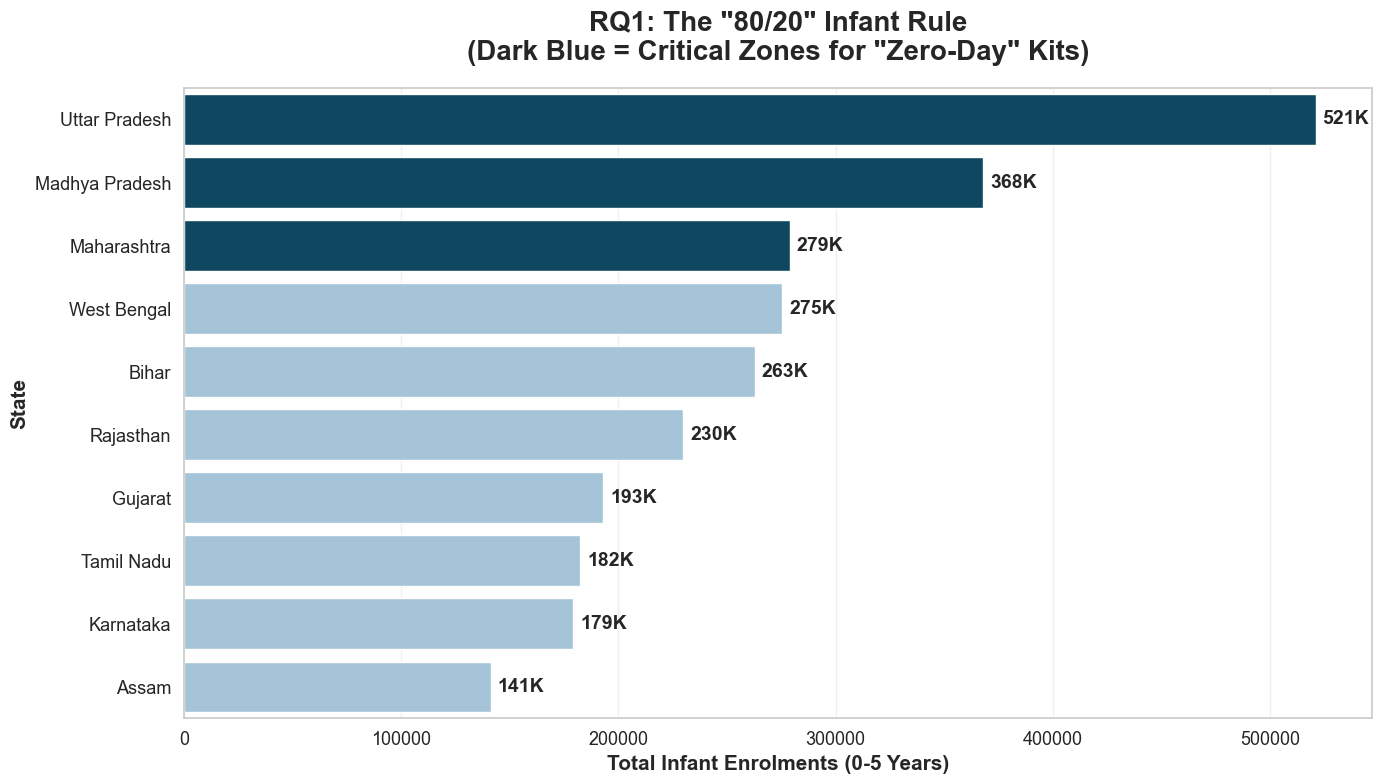

In [16]:
# --- CELL 8: THE SOLUTION VISUALIZATIONS (IMPROVED & READABLE) ---
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

# 1. SETUP PROFESSIONAL STYLE
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 20        # Bigger Title
plt.rcParams['axes.labelsize'] = 15        # Bigger Axis Labels
plt.rcParams['xtick.labelsize'] = 13       # Bigger X Ticks
plt.rcParams['ytick.labelsize'] = 13       # Bigger Y Ticks
plt.rcParams['legend.fontsize'] = 13       # Bigger Legend

# ---------------------------------------------------------
# 1. RQ1: THE "80/20" INFANT RULE (Targeting Strategy)
# ---------------------------------------------------------
plt.figure(figsize=(14, 8)) # Increased size for better visibility

# NEW COLOR SCHEME: Deep Royal Blue for Critical (Top 3), Muted Steel Blue for the rest
colors_v1 = ['#004c6d' if i < 3 else '#9dc6e0' for i in range(len(top_infant_states))]

ax1 = sns.barplot(data=top_infant_states, x='age_0_5', y='state', palette=colors_v1)

# Add Labels (Larger Font)
for container in ax1.containers:
    ax1.bar_label(container, fmt=lambda x: f'{x/1000:.0f}K', padding=5, fontweight='bold', fontsize=14)

plt.title('RQ1: The "80/20" Infant Rule\n(Dark Blue = Critical Zones for "Zero-Day" Kits)', fontweight='bold', pad=20)
plt.xlabel('Total Infant Enrolments (0-5 Years)', fontweight='bold')
plt.ylabel('State', fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\saikr\AppData\Local\Temp\ipykernel_12980\1514786375.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=monthly_bio_updates, x='month_name', y='bio_age_5_17', palette=colors_v2)


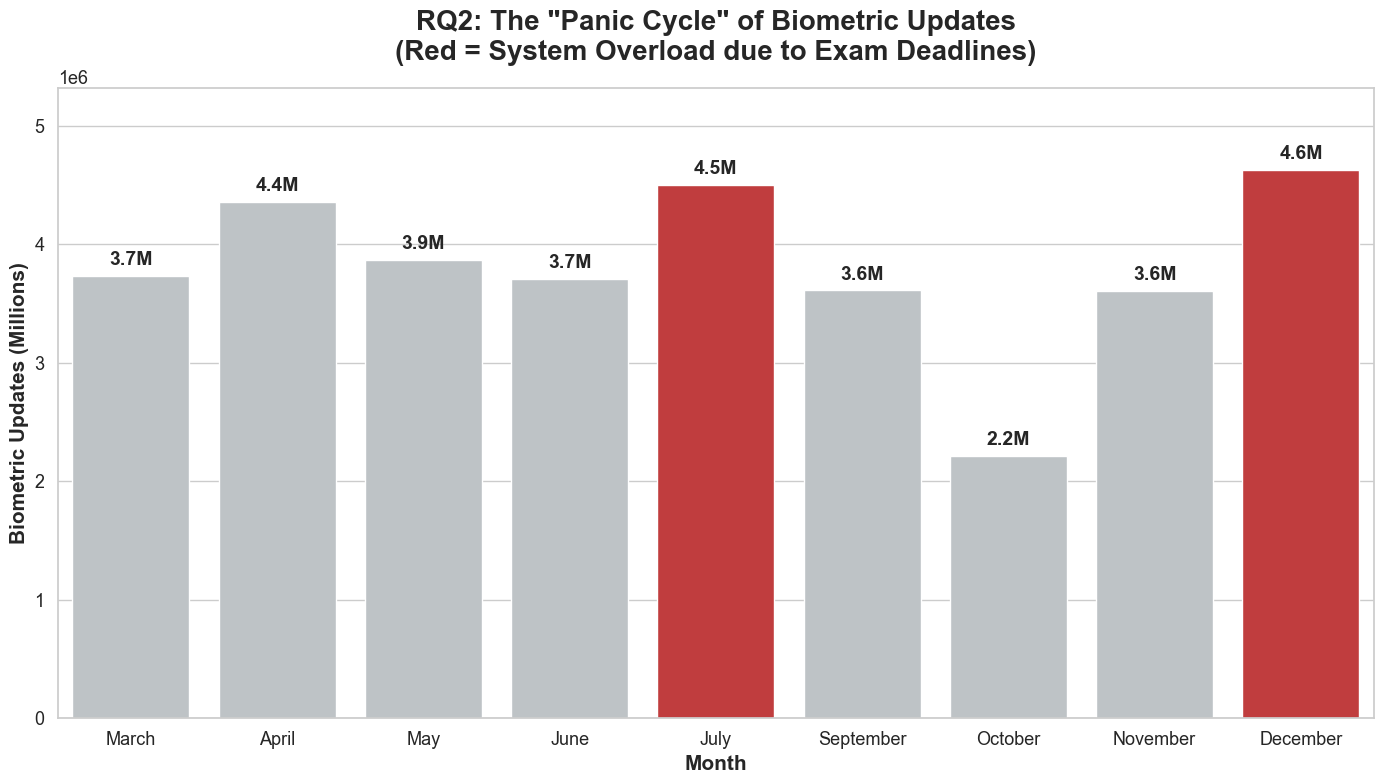

In [17]:
# ---------------------------------------------------------
# 2. RQ2: THE "PROCRASTINATION PENALTY" (Seasonality)
# ---------------------------------------------------------
plt.figure(figsize=(14, 8))

# Colors: Bright Red for Panic Months, Neutral Grey for others
colors_v2 = ['#d62728' if m in ['July', 'December'] else '#bdc3c7' for m in monthly_bio_updates['month_name']]

ax2 = sns.barplot(data=monthly_bio_updates, x='month_name', y='bio_age_5_17', palette=colors_v2)

# Add Labels (Larger Font)
for container in ax2.containers:
    ax2.bar_label(container, fmt=lambda x: f'{x/1000000:.1f}M', padding=5, fontweight='bold', fontsize=14)

plt.title('RQ2: The "Panic Cycle" of Biometric Updates\n(Red = System Overload due to Exam Deadlines)', fontweight='bold', pad=20)
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Biometric Updates (Millions)', fontweight='bold')
plt.ylim(0, monthly_bio_updates['bio_age_5_17'].max() * 1.15) # Headroom for labels
plt.tight_layout()
plt.show()


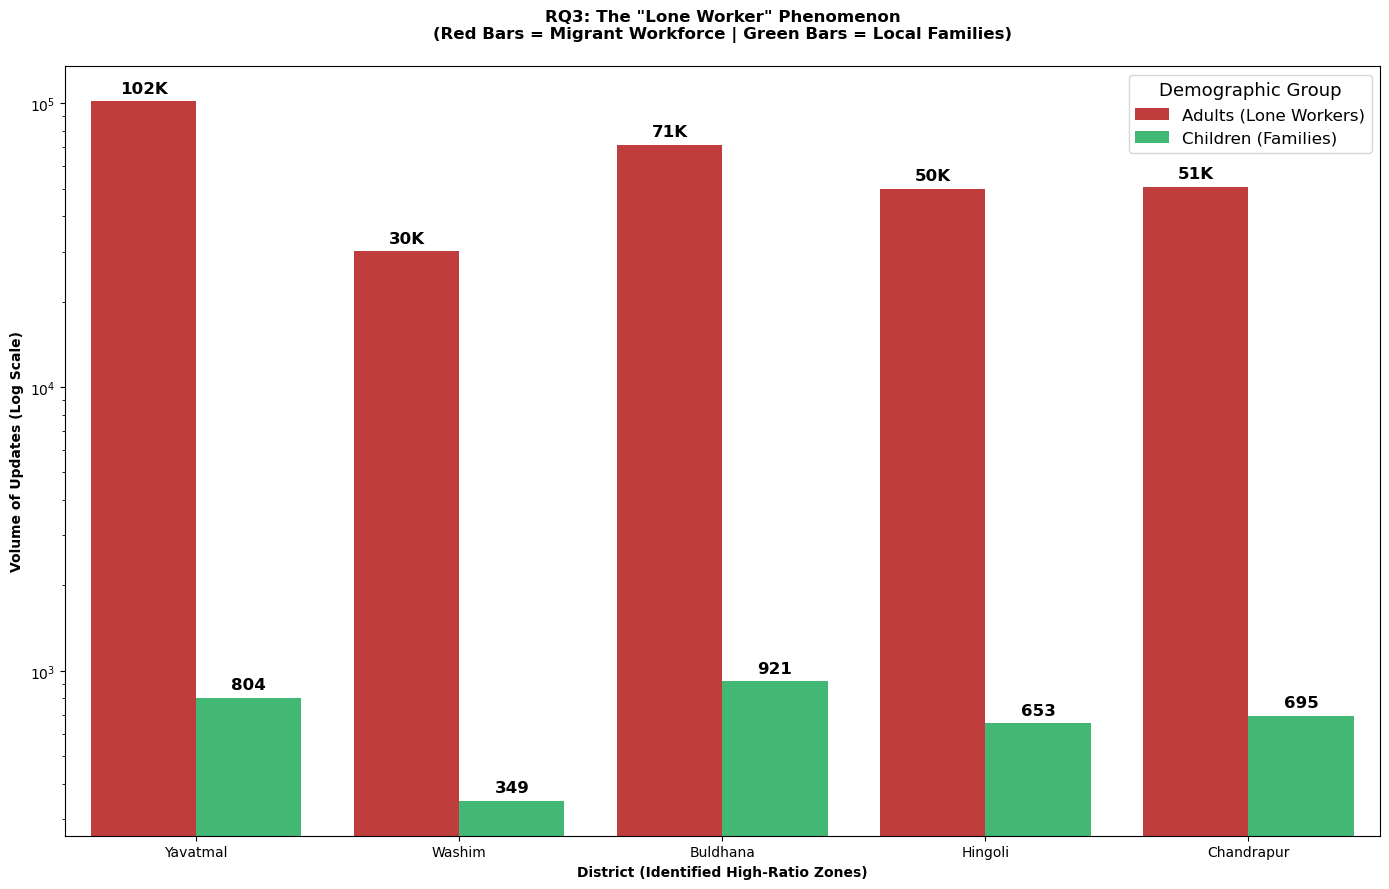

In [9]:
# ---------------------------------------------------------
# 3. RQ3: THE "LONE WORKER" DETECTOR (Migration Hubs)
# ---------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

# Prepare data
hub_data = migration_hubs[['district', 'demo_age_17_', 'demo_age_5_17']].melt(
    id_vars='district', 
    var_name='Type', 
    value_name='Count'
)
hub_data['Type'] = hub_data['Type'].map({
    'demo_age_17_': 'Adults (Lone Workers)', 
    'demo_age_5_17': 'Children (Families)'
})

plt.figure(figsize=(14, 9))

# Log Scale Plot
ax3 = sns.barplot(
    data=hub_data, 
    x='district', 
    y='Count', 
    hue='Type', 
    palette={'Adults (Lone Workers)': '#d62728', 'Children (Families)': '#2ecc71'}
)

plt.yscale('log') # Log scale handles the massive difference

# CLEAN LABELS (Larger Font, K notation)
for container in ax3.containers:
    labels = [f'{v/1000:.0f}K' if v > 1000 else f'{v:.0f}' for v in container.datavalues]
    ax3.bar_label(container, labels=labels, padding=4, fontweight='bold', fontsize=12)

plt.title('RQ3: The "Lone Worker" Phenomenon\n(Red Bars = Migrant Workforce | Green Bars = Local Families)', fontweight='bold', pad=20)
plt.ylabel('Volume of Updates (Log Scale)', fontweight='bold')
plt.xlabel('District (Identified High-Ratio Zones)', fontweight='bold')
plt.legend(title='Demographic Group', loc='upper right', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()